In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import argparse
import h5py
from scipy.stats import t as student_t
from statsmodels.stats import multitest as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
subjects_to_be_ignored = [21269692]
subject_sex = 'male'
prototype_flag = True

deconfound_flag = True
# if deconfound_flag == True:
#     import matlab.engine
#     eng = matlab.engine.start_matlab()
    
IDP_cuttoff_nan = 1.0
vars_cutoff_nan = 0.1

In [15]:
# Identify Correct File to Load

IDP_file = 'male_testB_IDPs.h5'
confounds_file = 'male_testB_conf12.h5'
data_file = 'male_testB.pkl'

confounds = h5py.File(confounds_file, 'r')
confounds = confounds['conf12'][()]

IDP_h5 = h5py.File(IDP_file, 'r')
subjects_h5 = IDP_h5['subjects'][()]

# Load the relevant dataframe based on the required modality

df = pd.read_pickle(data_file)

IDP_h5 = h5py.File(IDP_file, 'r')
IDPs_i_deconf = IDP_h5['IDPs1_i_deconf'][()]
vars_i_deconf = IDP_h5['vars_i_deconf'][()]
subjects_h5 = IDP_h5['subjects'][()]

# Useful Functions

# def deconfound_inputs(deltas):
    
#     confounds = h5py.File('ICA/male_test_conf12.h5', 'r')
#     confounds = confounds['conf12'][()]
    
#     deltas_deconfounds = eng.NetsUnconfoundWrapper(eng.transpose(matlab.double(deltas.tolist())), 
#                                   matlab.double(confounds.tolist()))
    
#     deltas_deconfounds = np.asarray(deltas_deconfounds).flatten()
    
#     return deltas_deconfounds

def deconfound_inputs(y):
    
    y = y - y.mean(axis=0)
    if np.sum(np.isnan(y)) == 0:
        beta = np.linalg.pinv(confounds).dot(y)
        beta[np.abs(beta) < 1e-10] = 0
        yd = y - confounds.dot(beta)
        yd = yd - yd.mean()
    else:
        print('ERROR! Encoundered a NaN! Function Needs Updating!')
    
    return yd

def apply_FDR_correction(p_values):
    '''
    Code addapted from Emma Bluemke & Nicola Dinsdale
    Wrapper for Benjamini/Hochberg (non-negative) p-value correction for multiple tests.
    '''
    p_values_corrected = mt.multipletests(p_values, alpha=0.05, method='fdr_bh')[1] 
    
    return p_values_corrected


def standardize_data(variables):
    '''
    Code addapted from Emma Bluemke & Nicola Dinsdale
    '''

    number_of_subjects=variables.shape[0]

    # Compute the arithmetic mean & std along the specified axis, ignoring NaNs.
    variables_mean_ignore_NaNs = np.nanmean(variables,axis=0)
    variables_std_ignore_NaNs = np.nanstd(variables,axis=0)

    # We standardize the data
    variables_scaled = variables - np.tile(variables_mean_ignore_NaNs,(number_of_subjects,1))
    variables_scaled = variables_scaled / np.tile(variables_std_ignore_NaNs,(number_of_subjects,1))

    # Calculate how many variables are non NaN
    number_of_non_NaN =np.sum(np.isnan(variables)==False,axis=0) #np.nanstd has N**0.5 in divisor

    return variables_scaled, number_of_non_NaN


def correlate_with_fdr_correction(deltas, ukb_variables):
    """
    Code addapted from Emma Bluemke & Nicola Dinsdale

    correlate age deltas with rows in ukb_variables
    returns pearson_r, t_test_statistic, p_values_corrected, p_values of length number_of_variables

    pearson_r = raw Pearson correlation value (between -1 and 1)
    t_test_statistic t test statistic for each variable ()
    p_values_corrected is corrected p-values values (fdr corrected)
    p_values is non corrected p-values
    """

    ukb_variables_scaled , ukb_variales_number_of_non_NaN = standardize_data(ukb_variables)
    ukb_variables_NaN_matrix = np.isnan(ukb_variables_scaled)
    ukb_variables_scaled[ukb_variables_NaN_matrix] = 0

    sys.stdout.flush()

    number_of_variables = ukb_variables_scaled.shape[1]

    deltas_array = np.tile(deltas,(number_of_variables,1)).T
    deltas_array[ukb_variables_NaN_matrix] = np.nan
    deltas_array = standardize_data(deltas_array)[0]
    deltas_array[ukb_variables_NaN_matrix] = 0

    pearson_r = np.sum(deltas_array * ukb_variables_scaled, axis=0) / ukb_variales_number_of_non_NaN
    
    t_test_statistic = pearson_r * ((ukb_variales_number_of_non_NaN-2)/(1-pearson_r**2))**0.5
    t_test_statistic = np.abs(t_test_statistic)
    t_test_statistic[ukb_variales_number_of_non_NaN <= 2] = np.nan #set those that had d.o.f 0 to nan

    p_values=np.zeros(len(t_test_statistic))
    for j in range(len(t_test_statistic)):
        if t_test_statistic[j] is not np.nan:
            p_values[j] = student_t.sf(t_test_statistic[j], ukb_variales_number_of_non_NaN[j] - 2) * 2
        else:
            p_values[j]=np.nan

    p_values_NaN_matrix = np.isnan(p_values)
    p_values_no_NaN = p_values[p_values_NaN_matrix==False]
    p_values_corrected_raw = apply_FDR_correction(p_values_no_NaN)

    p_values_corrected=np.zeros(len(p_values))
    p_values_corrected[p_values_NaN_matrix==False] = p_values_corrected_raw
    p_values_corrected[p_values_NaN_matrix==True] = np.nan

    return pearson_r, t_test_statistic, p_values_corrected, p_values

def align_subjects(subjects_df, subjects_h5, age_delta_decon, subjects_to_be_ignored):
    '''
    Here we make sure that the subjects match between the results and the nIDP/IDP dataframes
    The subjects_df uses slightly older data, and subjects might have left the study since it's generation
    If need be, this will be corrected at a later stage!
    '''
    
    if len(subjects_df) == len(subjects_h5):
        assert (subjects_df == subjects_h5).all()
    else:
        idx_elim = np.where(subjects_df == subjects_to_be_ignored)[0][0]
        subjects_df = np.delete(subjects_df, idx_elim)
        assert (subjects_df == subjects_h5).all()
        age_delta_decon = np.delete(age_delta_decon, idx_elim)
    return subjects_df, age_delta_decon

def FDR(p, q):
    # Remove NaNs
    p = p[~np.isnan(p)]
    # Sort the p-values
    p = np.sort(p)
    V = len(p)
    I = np.arange(1, V+1)

    cVID = 1.0
    cVN = np.sum(1.0 / np.arange(1, V+1))

    # Get the indices of p-values that are less than or equal to the calculated threshold.
    # Then, find the maximum of these indices.
    # If no such indices exist, the result will be an empty array.
    pID_indices = np.where(p <= I/V*q/cVID)[0]
    pN_indices = np.where(p <= I/V*q/cVN)[0]

    # Check if the result is empty. If so, the p-value is zero.
    # Otherwise, get the maximum index and use it to find the p-value from the sorted array.
    pID = p[pID_indices[-1]] if pID_indices.size else 0
    pN = p[pN_indices[-1]] if pN_indices.size else 0

    return pID, pN

def correlations_and_plots(age_delta_decon, deconf_subset, names_subset, idxs, categories_subset, title, 
                           corr_flag='IDP'):
    
    corr_results = correlate_with_fdr_correction(age_delta_decon, deconf_subset)
    
    corr_df = pd.DataFrame.from_dict({
        'idx': idxs,
        "names": names_subset,
        'Categories': categories_subset,
        "pearson_r": corr_results[0],
        "t_test_statistic": corr_results[1],
        "p_values_corrected": corr_results[2],
        "p_values": corr_results[3],
        "abs_pearson_r": np.abs(corr_results[0]),
        "log_p_values": -np.log10(corr_results[3]),
        "log_p_values_corrected": -np.log10(corr_results[2]),
    })
    
    if corr_flag == 'IDP':
        short_p_values = np.extract(corr_df.p_values !=0, corr_df.p_values)
        bonferroni_threshold = 0.05/len(short_p_values) #... Bonferroni
    else:
        bonferroni_threshold = 0.05/len(corr_df.p_values) #... Bonferroni
    bonferroni_threshold = -np.log10(bonferroni_threshold)

#     arguments = np.argsort(corr_df.p_values_corrected)
#     sorted_p_values_corrected = corr_df.p_values_corrected[arguments]
#     sorted_p_values = corr_df.p_values[arguments]
#     if len(sorted_p_values_corrected[sorted_p_values_corrected<=0.05]):
# #         arguments_no_NaN = np.nanmax(sorted_p_values[sorted_p_values_corrected<=0.05])        
# #         false_discovery_rate = sorted_p_values[arguments_no_NaN]

#         false_discovery_rate = np.nanmax(sorted_p_values[sorted_p_values_corrected<=0.05])
# #         false_discovery_rate = np.nanmax(sorted_p_values_corrected[sorted_p_values_corrected<=0.05])
#         false_discovery_rate = -np.log10(false_discovery_rate)
#         FDR_flag = True
#     else:
#         FDR_flag = False
#         false_discovery_rate = None


#     arguments = np.argsort(corr_df.p_values_corrected)
#     sorted_p_values_corrected = corr_df.p_values_corrected[arguments]
#     sorted_p_values = corr_df.p_values[arguments]
#     if len(sorted_p_values_corrected[sorted_p_values_corrected<=0.05]):

#         pID, pN = FDR(sorted_p_values, 0.05)  # Here we calculate the FDR using the correct function
#         false_discovery_rate = pN  # Use pN (Nonparametric p-value threshold) as the false discovery rate
#         false_discovery_rate = -np.log10(false_discovery_rate)  # Convert to -log10 scale
#         FDR_flag = True
#     else:
#         FDR_flag = False
#         false_discovery_rate = None


    p_values = corr_df.p_values.dropna().values # drop NaNs from p-values

    pID, _ = FDR(p_values, 0.05) # calculate FDR using provided function

    if pID > 0:
        FDR_flag = True
        false_discovery_rate = -np.log10(pID)
    else:
        FDR_flag = False
        false_discovery_rate = None


    if corr_flag == 'IDP':
        x_text_location = -120
        bonferroni_threshold_text = 1
        false_discovery_rate_text = -2
        colorCycle = 'Paired'
    else:
        x_text_location = -750
        bonferroni_threshold_text = 0.1
        false_discovery_rate_text = -0.5
        colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']
#         colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']


    
    
    plt.figure(figsize=(16, 9.6))
    
    if corr_flag == 'IDP':
        sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                    y='log_p_values', hue='Categories', 
                        palette=colorCycle
                       )
    else:
        sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                    y='log_p_values', hue='Categories', 
                        palette=colorCycle
                       )  
    
    plt.ylabel('-log(P)')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.axhline(y = bonferroni_threshold, linestyle='--', color='r')
    plt.text(x=x_text_location, y=bonferroni_threshold + bonferroni_threshold_text, s='Bonf.')
    if false_discovery_rate is not None:
        plt.axhline(y = false_discovery_rate, linestyle='--', color='r')
        plt.text(x=x_text_location, y=false_discovery_rate + false_discovery_rate_text, s='FDR')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.show()
    
    return corr_df, bonferroni_threshold, false_discovery_rate



# IDP_names = np.loadtxt("IDP_names.txt", dtype=str, delimiter='\n')
with open('IDP_names.txt') as f:
    IDP_names = f.readlines()
    IDP_names = [l.strip('\n\r') for l in IDP_names]
    IDP_names = np.array(IDP_names)
# IDP_categories = np.loadtxt("IDP_categories.txt", dtype=str, delimiter='\n')
with open('IDP_categories.txt') as f:
    IDP_categories = f.readlines()
    IDP_categories = [l.strip('\n\r') for l in IDP_categories]
    IDP_categories = np.array(IDP_categories)
with open('varsHeader.txt') as f:
    varsHeader = f.readlines()
    varsHeader = [l.strip('\n\r') for l in varsHeader]
    varsHeader = np.array(varsHeader)
# vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')
with open('vars_categories.txt') as f:
    vars_categories = f.readlines()
    vars_categories = [l.strip('\n\r') for l in vars_categories]
    vars_categories = np.array(vars_categories)
    
    
IDPIDX = np.arange(0, len(IDP_names), 1).astype(int)
varsIDX = np.arange(0, len(varsHeader), 1).astype(int)

# # Identify Correct File to Load

# data_file = 'male'
# IDP_file = 'male'
# if subject_sex == 'female':
#     data_file = 'fe' + data_file
#     IDP_file = 'fe' + IDP_file
# if prototype_flag == True:
#     data_file += '_prototype'
# data_file += '.pkl'
# IDP_file += '_test_IDPs.h5'

# # Load the relevant dataframe based on the required modality

# df = pd.read_pickle(data_file)

# IDP_h5 = h5py.File(IDP_file, 'r')
# IDPs_i_deconf = IDP_h5['IDPs1_i_deconf'][()]
# vars_i_deconf = IDP_h5['vars_i_deconf'][()]
# subjects_h5 = IDP_h5['subjects'][()]

# Filter out those IDPs and Vars which have too many NaNs (see 7.1 for more details!)

IDP_perc_not_nan = np.sum(np.isnan(IDPs_i_deconf)==False,axis=0) / IDPs_i_deconf.shape[0]
vars_perc_not_nan = np.sum(np.isnan(vars_i_deconf)==False,axis=0) / vars_i_deconf.shape[0]
IDP_idx_nan_cutoff = np.where(IDP_perc_not_nan >= IDP_cuttoff_nan)[0]
vars_idx_nan_cutoff = np.where(vars_perc_not_nan >= vars_cutoff_nan)[0]

IDP_names_subset = IDP_names[IDP_idx_nan_cutoff]
IDPs_i_deconf_subset = IDPs_i_deconf[:, IDP_idx_nan_cutoff]
IDP_categories_subset = IDP_categories[IDP_idx_nan_cutoff]
varsHeader_subset = varsHeader[vars_idx_nan_cutoff]
vars_i_deconf_subset = vars_i_deconf[:, vars_idx_nan_cutoff]
vars_categories_subset = np.array(vars_categories)[vars_idx_nan_cutoff]
IDPIDX_subset = IDPIDX[IDP_idx_nan_cutoff]
varsIDX_subset = varsIDX[vars_idx_nan_cutoff]

del IDP_h5



In [16]:
type(vars_idx_nan_cutoff)

numpy.ndarray

In [17]:
vars_idx_nan_cutoff

array([    0,     1,     2, ..., 17507, 17525, 17526])

In [18]:
vars_categories_subset = np.array(vars_categories)[vars_idx_nan_cutoff]

In [19]:
vars_categories[0:2]

array(['Ethnic Background', 'Ethnic Background'], dtype='<U35')

In [20]:
df.head()

modality                                          dataframe
0  T1_nonlinear        Unnamed: 0  target_age  output_age_1  ag...
1     T1_linear        Unnamed: 0  target_age  output_age_1  ag...
2      jacobian        Unnamed: 0  target_age  output_age_1  ag...
3           vbm        Unnamed: 0  target_age  output_age_1  ag...
4  T2_nonlinear        Unnamed: 0  target_age  output_age_1  ag...

In [58]:
df.iloc[0].dataframe

Unnamed: 0  target_age  output_age_1  age_delta_1     loss_1  \
1995    22840726   77.611986     70.447640    -7.164347  51.327866   
2682    22538138   62.389384     65.735600     3.346220  11.197187   
1117    23586213   66.140753     63.993920    -2.146834   4.608896   
2651    23759858   68.352169     70.515680     2.163509   4.680773   
2346    22751665   50.348973     55.442696     5.093723  25.946014   
...          ...         ...           ...          ...        ...   
3054    22793991   58.971575     59.182907     0.211332   0.044661   
4252    22995420   59.511073     62.388176     2.877103   8.277721   
3414    21876262   66.540297     70.937590     4.397295  19.336201   
2500    24605415   74.999886     73.358284    -1.641602   2.694857   
3879    22979620   57.161758     56.895706    -0.266052   0.070784   

      output_age_2  age_delta_2     loss_2  output_age_3  age_delta_3  \
1995     70.705340    -6.906649  47.701797     69.752900    -7.859087   
2682     63.004715     0.615331   0.378633     67.894210     5.504827   
1117     66.692340     0.551584   0.304244     67.024450     0.883699   
2651     68.536150     0.183979   0.033848     69.441820     1.089649   
2346     53.351820     3.002849   9.017104     52.633340     2.284366   
...            ...          ...        ...           ...          ...   
3054     58.124040    -0.847537   0.718318     57.074930    -1.896647   
4252     63.492783     3.981710  15.854011     65.489105     5.978032   
3414     71.030716     4.490419  20.163864     71.160324     4.620027   
2500     74.501420    -0.498467   0.248469     73.867220    -1.132668   
3879     58.937485     1.775727   3.153205     56.487530    -0.674228   

         loss_3  mean_output_age  mean_age_delta  output_age_decon  \
1995  61.765251        70.301960       -7.310026         71.605132   
2682  30.303123        65.544842        3.155458         65.817924   
1117   0.780924        65.903570       -0.237183         66.254330   
2651   1.187336        69.497883        1.145714         70.626943   
2346   5.218330        53.809285        3.460313         51.541192   
...         ...              ...             ...               ...   
3054   3.597270        58.127292       -0.844283         56.794205   
4252  35.736869        63.790021        4.278948         63.683121   
3414  21.344652        71.042877        4.502580         72.506484   
2500   1.282936        73.908975       -1.090911         75.993197   
3879   0.454584        57.440240        0.278482         55.958381   

      age_delta_decon  
1995        -6.006854  
2682         3.428540  
1117         0.113577  
2651         2.274774  
2346         1.192219  
...               ...  
3054        -2.177371  
4252         4.172048  
3414         5.966187  
2500         0.993311  
3879        -1.203377  

[2183 rows x 15 columns]

In [59]:
np.unique(IDP_categories_subset)

array(['Regional and Tissue Volume', 'WM Tract Diffusivity',
       'WM Tract FA', 'WM Tract ICVF', 'WM Tract ISOVF', 'WM Tract MO',
       'WM Tract OD', 'White Matter Hyperintensity Colume',
       'rfMRI Connectivity', 'rfMRI Node Amplitude', 'tfMRI Activation'],
      dtype='<U34')

In [13]:
IDP_corrs = []
IDP_mods = []
IDP_bnf_thrs = []
IDP_fdr_thrs = []

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    modality = df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
    
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = IDPs_i_deconf_subset, 
                                    names_subset = IDP_names_subset, idxs = IDPIDX_subset,
                                    categories_subset = IDP_categories_subset,
                                    title = modality, corr_flag='IDP')
    IDP_mods.append(modality)
    IDP_corrs.append(corr_df)
    IDP_bnf_thrs.append(bonferroni_threshold)
    IDP_fdr_thrs.append(false_discovery_rate)
    
IDP_df = pd.DataFrame.from_dict({
    'modality': IDP_mods,
    'bonf': IDP_bnf_thrs,
    'fdr': IDP_fdr_thrs,
    'dataframe': IDP_corrs
})

AttributeError: 'DataFrame' object has no attribute 'age_delta_decon'

In [50]:
IDP_df.to_pickle('male_IDP_testB.pkl', protocol = 4)

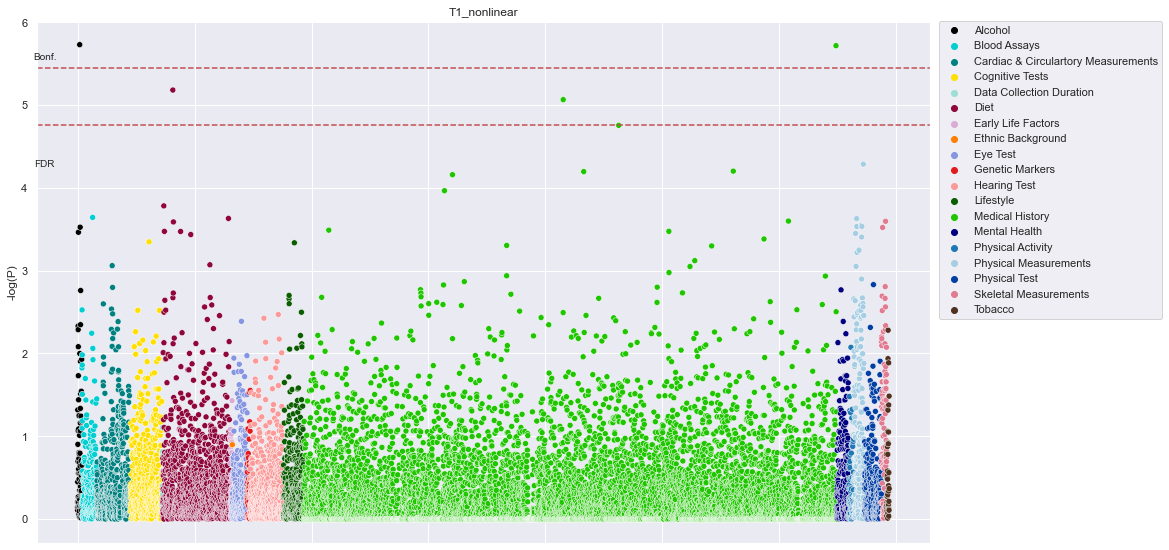

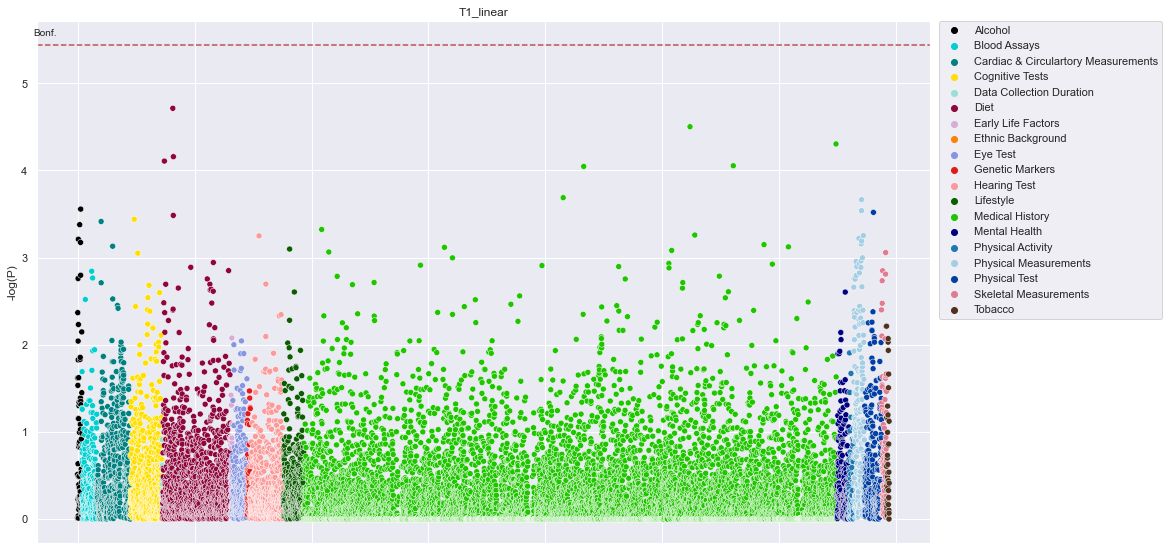

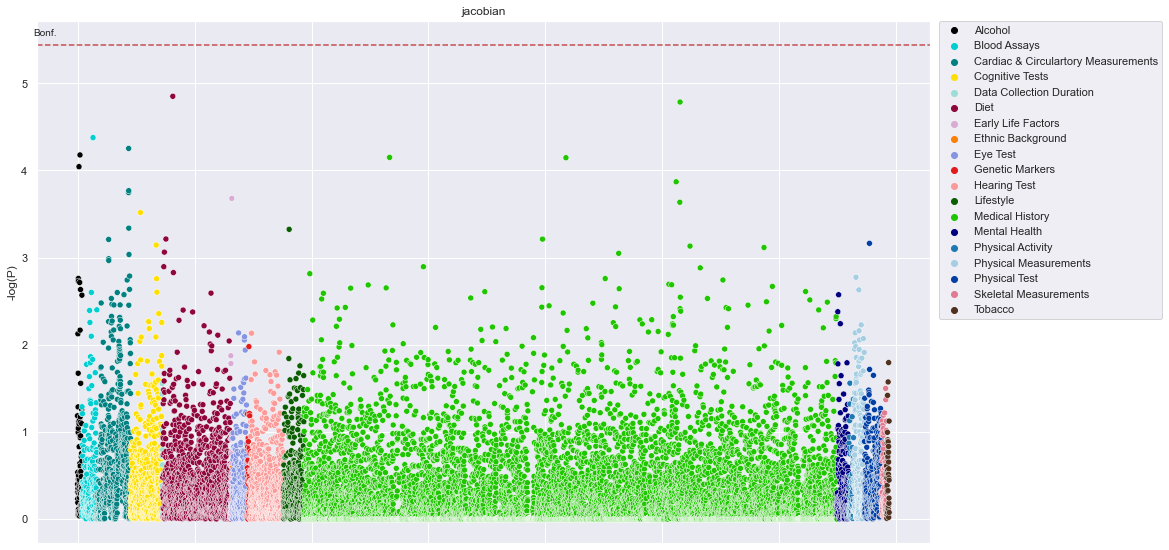

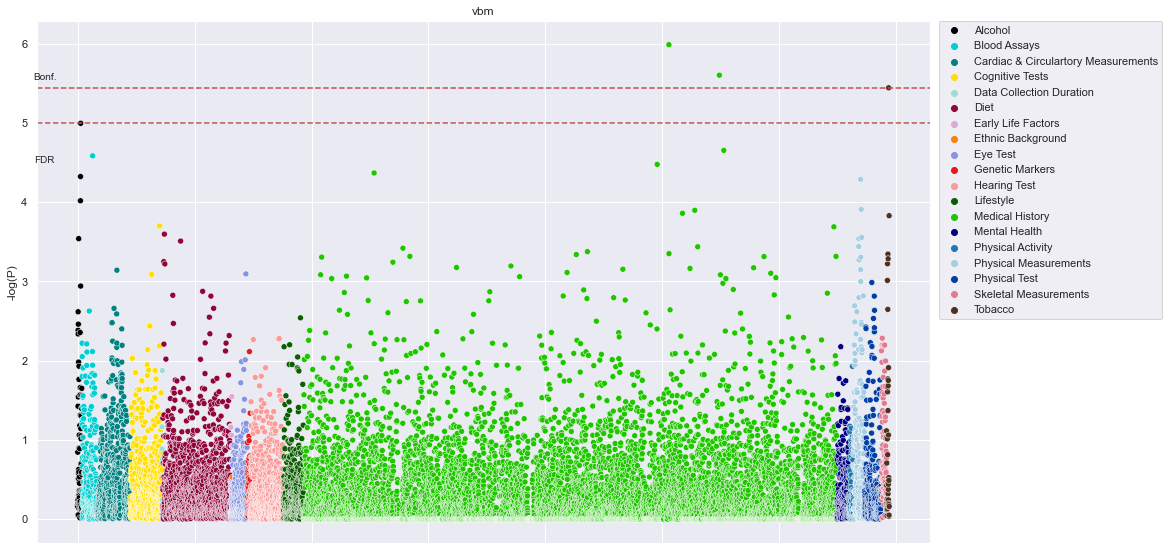

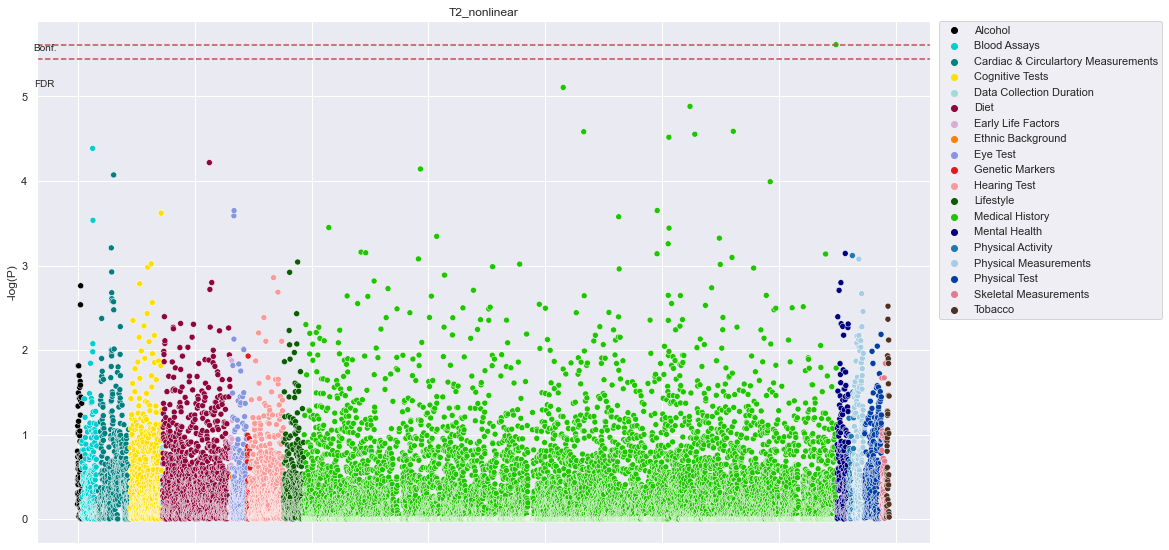

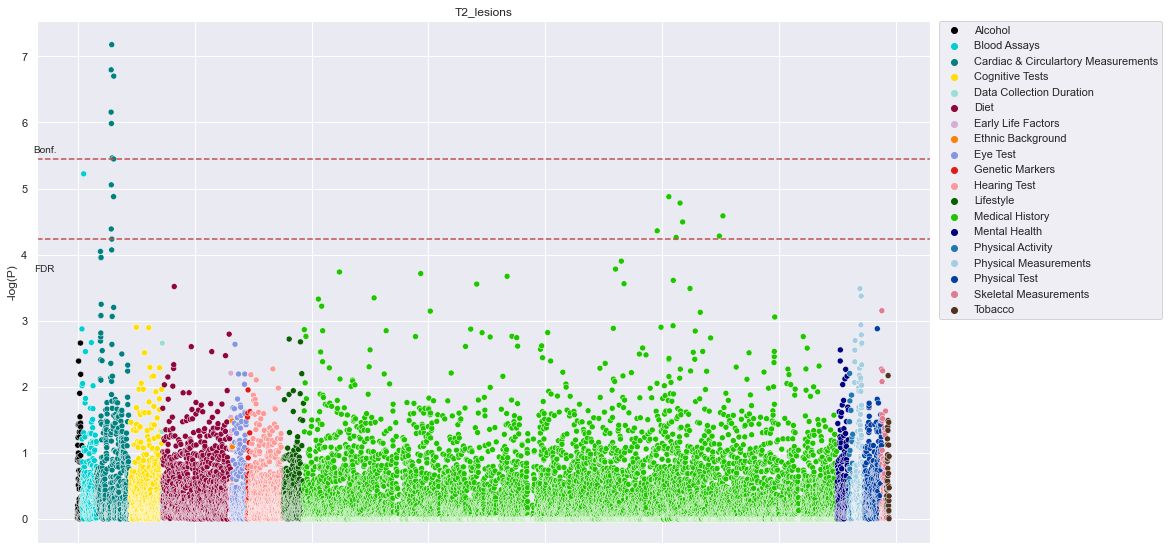

In [22]:
vars_corrs = []
vars_mods = []
vars_bnf_thrs = []
vars_fdr_thrs = []

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    modality = df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
        
        
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = vars_i_deconf_subset, 
                                    names_subset = varsHeader_subset, idxs = varsIDX_subset,
                                    categories_subset = vars_categories_subset,
                                    title = modality, corr_flag='vars')
    vars_mods.append(modality)
    vars_corrs.append(corr_df)
    vars_bnf_thrs.append(bonferroni_threshold)
    vars_fdr_thrs.append(false_discovery_rate)
    
    if idx == 5:
        break
    
vars_df = pd.DataFrame.from_dict({
    'modality': vars_mods,
    'bonf': vars_bnf_thrs,
    'fdr': vars_fdr_thrs,
    'dataframe': vars_corrs
})

In [23]:
vars_df.to_pickle('male_vars_testB.pkl', protocol = 4)

In [ ]:
# if deconfound_flag == True:
#     eng.quit()

In [26]:
# idp_df2 = IDP_df.iloc[np.where(IDP_df.modality=='swi')[0][0]].dataframe
# idp_df2[idp_df2.log_p_values>=idp_df2.bonferroni_threshold[0]].sort_values('log_p_values', ascending=False)

Plot the effect sizes (like R^2) for each significant hit. Have one plot in one view of associations. How much of the variace are we explaining the in the phenotype. 2 time point for longitudinal effects. 

In [6]:
df = pd.read_pickle('male_vars_testB.pkl')

In [24]:
def correlations_and_plots_replot(corr_df, bonferroni_threshold, false_discovery_rate, title,
                                 figsize,
                                  ticks_font_size,
                                  title_font_size,
                                  legend_font,
                                  save_title,
                                  ylabel = '-log(P)'
                                 ):


    colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']
    x_text_location = -750
    bonferroni_threshold_text = 0.00429570699569 * corr_df.log_p_values.values.max()
    false_discovery_rate_text = - 0.03436565596552 * corr_df.log_p_values.values.max()


    fig = plt.figure(figsize=figsize)
    sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                y='log_p_values', hue='Categories', palette=colorCycle)  

    plt.ylabel(ylabel, fontsize=title_font_size)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.axhline(y = bonferroni_threshold, linestyle='--', color='b',  linewidth = 2)
    plt.text(x=x_text_location, y=bonferroni_threshold + 2*bonferroni_threshold_text, s='Bonf.', fontsize=legend_font, color='b')
    if false_discovery_rate is not None:
        plt.axhline(y = false_discovery_rate, linestyle='--', color='r',  linewidth = 2)
        plt.text(x=x_text_location, y=false_discovery_rate + 2*false_discovery_rate_text, s='FDR', fontsize=legend_font, color='r')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=legend_font)
    plt.title(title, fontsize=title_font_size)
    plt.xticks(fontsize= ticks_font_size)
    plt.yticks(fontsize= ticks_font_size)
    
    fig.savefig(save_title, bbox_inches='tight')

In [25]:
df = pd.read_pickle('male_vars_testB.pkl')

In [26]:
df

modality      bonf       fdr  \
0  T1_nonlinear  5.443326  4.755399   
1     T1_linear  5.443326       NaN   
2      jacobian  5.443326       NaN   
3           vbm  5.443326  4.996503   
4  T2_nonlinear  5.443326  5.612791   
5    T2_lesions  5.443326  4.235209   

                                           dataframe  
0           idx                                  ...  
1           idx                                  ...  
2           idx                                  ...  
3           idx                                  ...  
4           idx                                  ...  
5           idx                                  ...

IndexError: single positional indexer is out-of-bounds

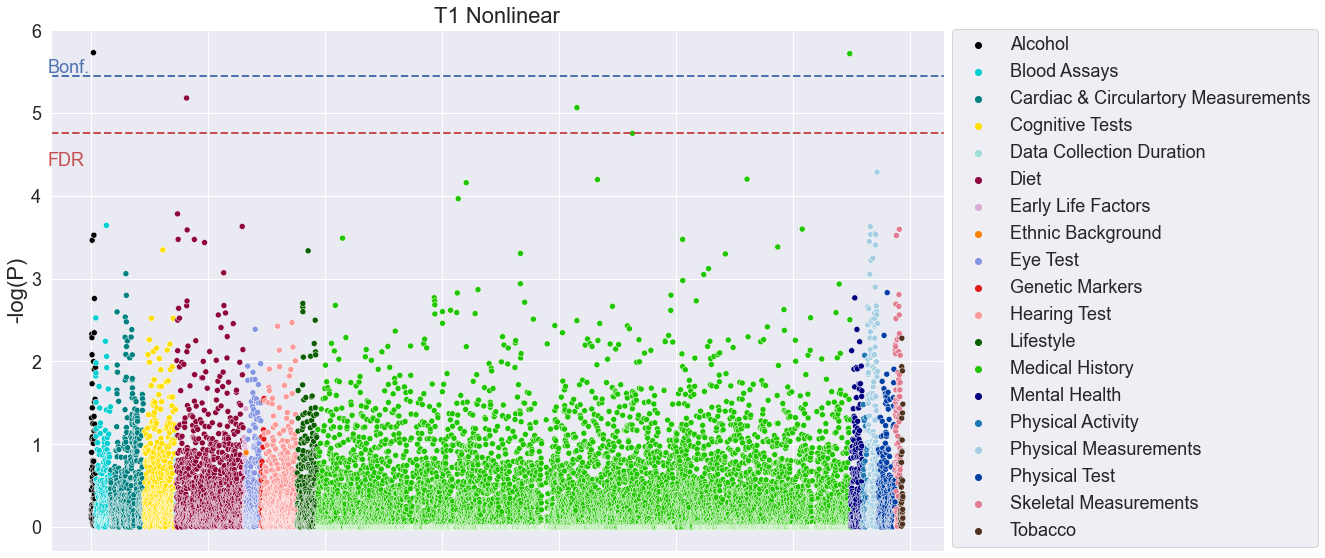

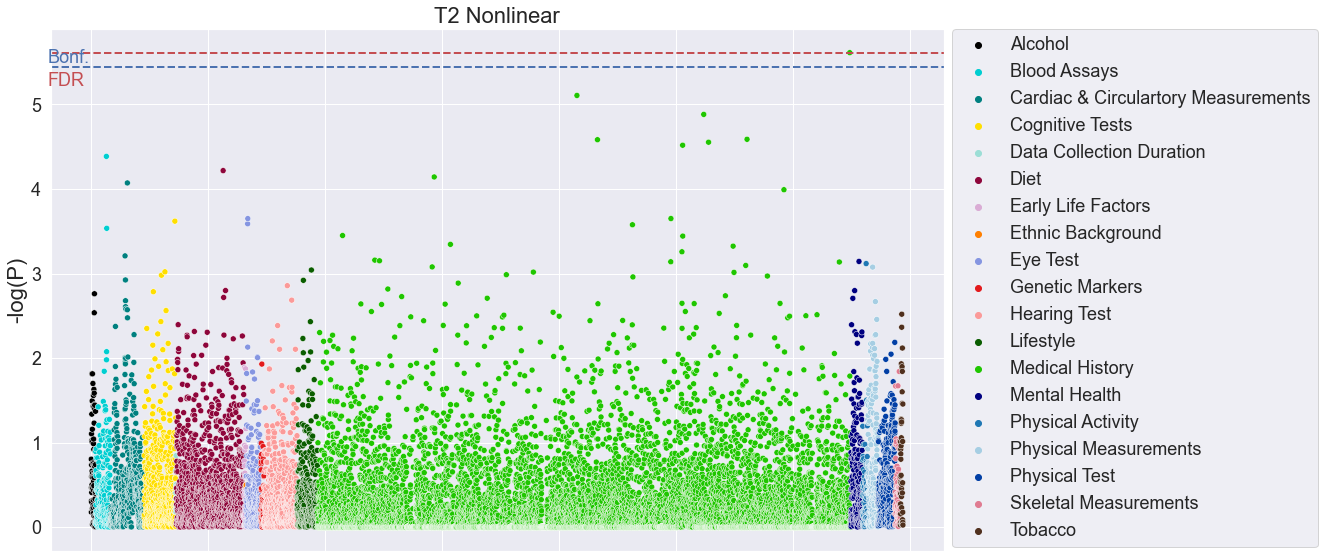

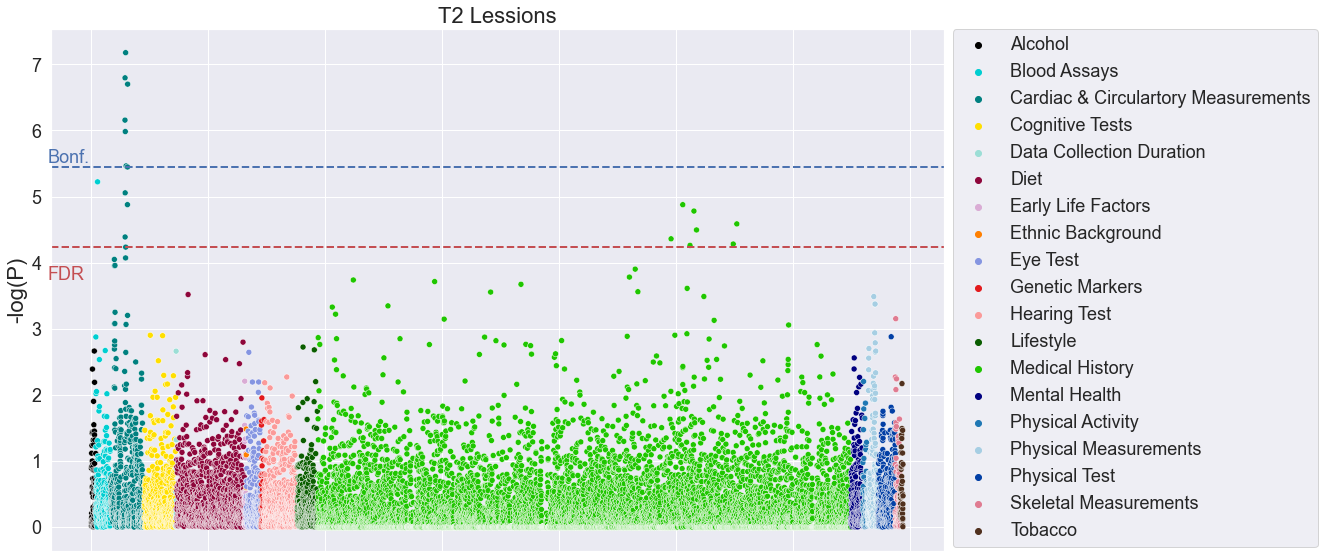

In [27]:
titles = [
    'T1 Nonlinear', 'T2 Nonlinear', 'T2 Lessions', 'SWI', 'rsfMRI-0', 
    'rsfMRI-12', 'tfMRI-2', 'tfMRI-COPE-2',
    'Summed Tracts', 'TBSS FA', 'FA', 
]

modality_indexes = [0, 4, 5, 6, 7, 19, 33, 36, 38, 39, 48]

save_title = 'Male_Manhattan_Plots'

title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

i = 0

for idx in modality_indexes:
    corr_df = df.iloc[idx].dataframe
    bonferroni_threshold = df.iloc[idx].bonf
    false_discovery_rate = df.iloc[idx].fdr
    title = df.iloc[idx].modality
    
    tmp_save_title = save_title + '_' + titles[i] + '.png'
    
    correlations_and_plots_replot(corr_df=corr_df, 
                                   bonferroni_threshold=bonferroni_threshold, 
                                   false_discovery_rate=false_discovery_rate,
                                   title=titles[i],
                                  figsize=figsize,
                                  ticks_font_size = ticks_font_size,
                                  title_font_size = title_font_size,
                                  legend_font = legend_font,
                                  save_title = tmp_save_title
                                  )

    i+=1

Female_Manhattan_Plots_Male Subjects: sMRI (T1 Nonlinear) - Phenotype Associations.png


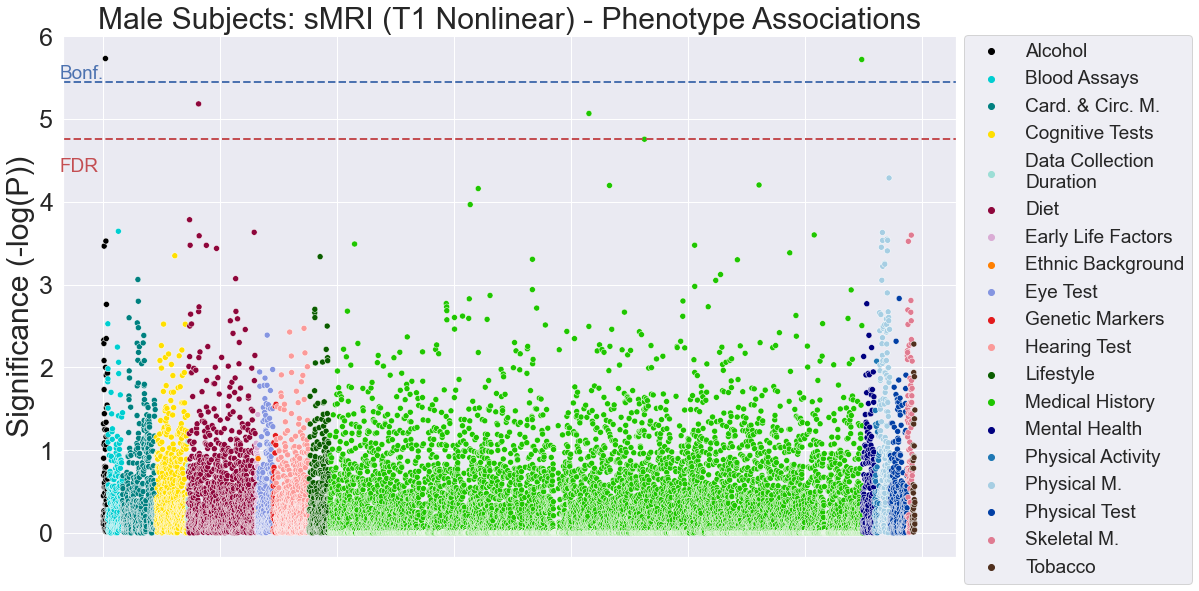

In [11]:
titles = [
    'Male Subjects: sMRI (T1 Nonlinear) - Phenotype Associations' 
]

modality_indexes = [0]

save_title = 'Female_Manhattan_Plots'

title_font_size=30
ticks_font_size=25
legend_font = 19
figsize=(16, 9.6)

i = 0

for idx in modality_indexes:
    corr_df = df.iloc[idx].dataframe
    
    corr_df.loc[corr_df['Categories'] == 'Cardiac & Circulartory Measurements', 'Categories'] = 'Card. & Circ. M.'
    corr_df.loc[corr_df['Categories'] == 'Physical Measurements', 'Categories'] = 'Physical M.'
    corr_df.loc[corr_df['Categories'] == 'Skeletal Measurements', 'Categories'] = 'Skeletal M.'
    corr_df.loc[corr_df['Categories'] == 'Data Collection Duration', 'Categories'] = 'Data Collection\nDuration'
    
    
    bonferroni_threshold = df.iloc[idx].bonf
    false_discovery_rate = df.iloc[idx].fdr
    title = df.iloc[idx].modality
    
    tmp_save_title = save_title + '_' + titles[i] + '.png'
    
    correlations_and_plots_replot(corr_df=corr_df, 
                                   bonferroni_threshold=bonferroni_threshold, 
                                   false_discovery_rate=false_discovery_rate,
                                   title=titles[i],
                                  figsize=figsize,
                                  ticks_font_size = ticks_font_size,
                                  title_font_size = title_font_size,
                                  legend_font = legend_font,
                                  save_title = tmp_save_title, 
                                  ylabel = 'Significance (-log(P))'
                                  )

    i+=1
    
    print(tmp_save_title)